In [1]:
import pandas as pd

# Encoding with ISO-8859-1 (UTF-8 will not work)
df = pd.read_csv("online_retail.csv", encoding="ISO-8859-1")
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [2]:
# Check Dataset
df.shape
df.head()
df.info()

df.isna().sum()
df.duplicated().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


5268

In [3]:
# Convert InvoiceDate to datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Create Revenue Column
df["Revenue"] = df["Quantity"] * df["UnitPrice"]

# Baseline Metrics
total_revenue = df["Revenue"].sum()
avg_order_value = df.groupby("InvoiceNo")["Revenue"].sum().mean()
top_countries = df.groupby("Country")["Revenue"].sum().sort_values(ascending=False).head(10)

total_revenue, avg_order_value, top_countries

(9747747.933999998,
 376.3609240926641,
 Country
 United Kingdom    8187806.364
 Netherlands        284661.540
 EIRE               263276.820
 Germany            221698.210
 France             197403.900
 Australia          137077.270
 Switzerland         56385.350
 Spain               54774.580
 Belgium             40910.960
 Sweden              36595.910
 Name: Revenue, dtype: float64)

In [4]:
df.duplicated().sum()


5268

In [5]:
clean_df = df.copy()

# Remove missing CustomerID
clean_df = clean_df.dropna(subset=["CustomerID"])

# Remove negatives and Zero quantities
clean_df = clean_df[clean_df["Quantity"] > 0]

# Remove zero or negative prices
clean_df = clean_df[clean_df["UnitPrice"] > 0]

# Remove canceled invoices
clean_df = clean_df[~clean_df["InvoiceNo"].astype(str).str.startswith("C")]

# Remove duplicates
clean_df = clean_df.drop_duplicates()

# Recompute revenue
clean_df["Revenue"] = clean_df["Quantity"] * clean_df["UnitPrice"]

# Check size difference
df.shape, clean_df.shape


((541909, 9), (392692, 9))

In [6]:
clean_total_revenue = clean_df["Revenue"].sum()
clean_avg_order_value = clean_df.groupby("InvoiceNo")["Revenue"].sum().mean()
clean_top_countries = clean_df.groupby("Country")["Revenue"].sum().sort_values(ascending=False).head(10)

clean_total_revenue, clean_avg_order_value, clean_top_countries


(8887208.894,
 479.56016047917126,
 Country
 United Kingdom    7285024.644
 Netherlands        285446.340
 EIRE               265262.460
 Germany            228678.400
 France             208934.310
 Australia          138453.810
 Spain               61558.560
 Switzerland         56443.950
 Belgium             41196.340
 Sweden              38367.830
 Name: Revenue, dtype: float64)

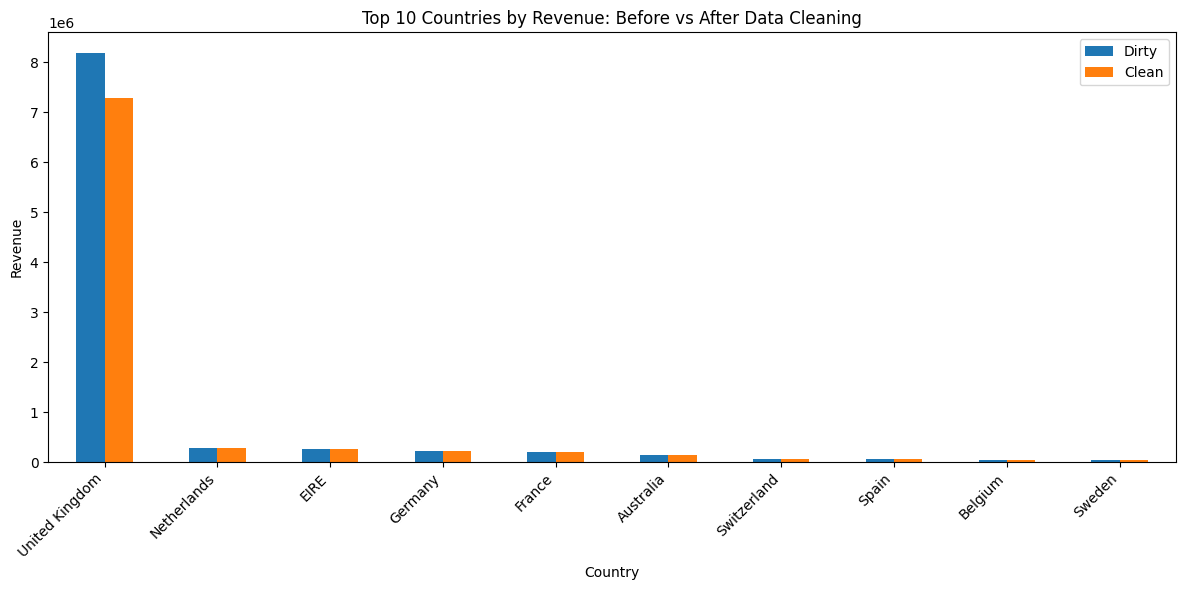

In [7]:
import matplotlib.pyplot as plt

# Aggregate revenue by country
dirty_country_rev = df.groupby("Country")["Revenue"].sum().sort_values(ascending=False).head(10)
clean_country_rev = clean_df.groupby("Country")["Revenue"].sum().sort_values(ascending=False).head(10)

# Combine into one dataframe
compare_countries = (
    dirty_country_rev.rename("Dirty")
    .to_frame()
    .join(clean_country_rev.rename("Clean"), how="inner")
)

# The Plot
compare_countries.plot(kind="bar", figsize=(12,6))
plt.title("Top 10 Countries by Revenue: Before vs After Data Cleaning")
plt.ylabel("Revenue")
plt.xlabel("Country")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


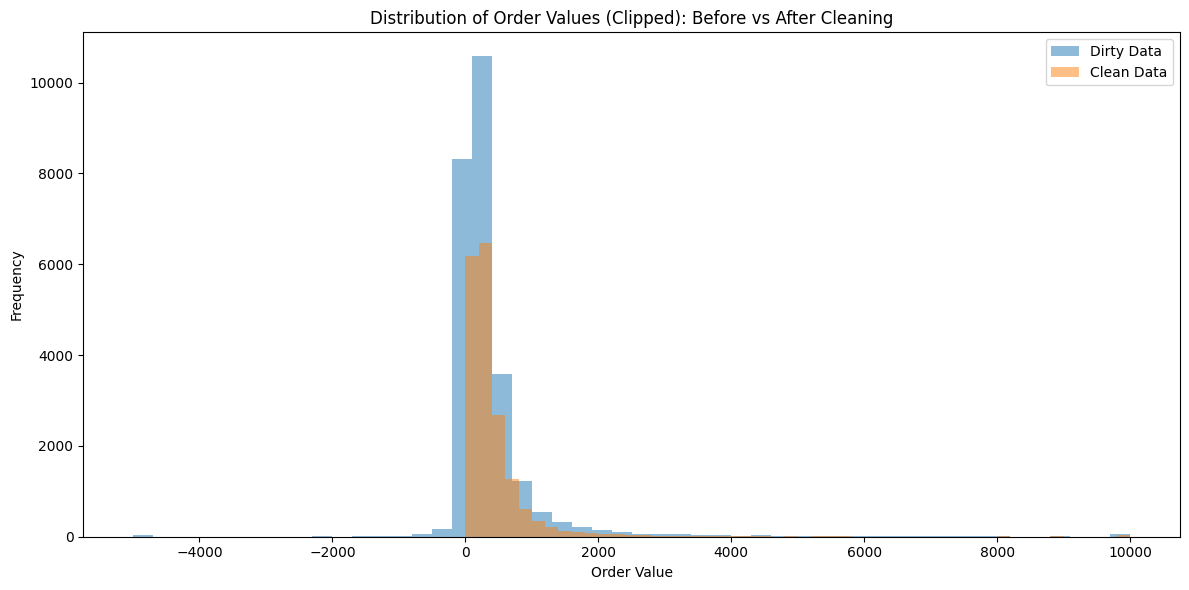

In [13]:
# Compute order totals
dirty_orders = df.groupby("InvoiceNo")["Revenue"].sum()
clean_orders = clean_df.groupby("InvoiceNo")["Revenue"].sum()

# Clip extreme values for visualization
dirty_orders_clip = dirty_orders.clip(lower=-5000, upper=10000)
clean_orders_clip = clean_orders.clip(lower=-5000, upper=10000)

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.hist(dirty_orders_clip, bins=50, alpha=0.5, label="Dirty Data")
plt.hist(clean_orders_clip, bins=50, alpha=0.5, label="Clean Data")

plt.title("Distribution of Order Values (Clipped): Before vs After Cleaning")
plt.xlabel("Order Value")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

